In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
image = cv2.imread('image.png')

In [3]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

In [4]:
lower = np.array([10, 10, 10])
upper = np.array([255, 255, 255])
lower1 = np.array([0, 100, 100])
upper1 = np.array([10, 255, 255])
lower2 = np.array([170, 100, 100])
upper2 = np.array([180, 255, 255])
mask = cv2.inRange(hsv, lower, upper)
mask1 = cv2.inRange(hsv, lower1, upper1)
mask2 = cv2.inRange(hsv, lower2, upper2)
maskr = mask1 | mask2

In [34]:
cv2.imshow('Binary image', maskr)
cv2.waitKey(0)
cv2.imwrite('image_thres1.jpg', maskr)
cv2.destroyAllWindows()

In [5]:
contours, hierarchy = cv2.findContours(image=mask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
contoursr, hierarchyr = cv2.findContours(image=maskr, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

In [7]:
cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
cv2.imshow('Contours', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
def func(x, y):
    cross = x * (np.roll(y, 1) - np.roll(y, -1)) - y * (np.roll(x, 1) - np.roll(x, -1))
    radii = x * x + y * y
    return -0.5*(cross / (radii**(3/2))).sum()

In [14]:
circle = contoursr[0].squeeze()
irloop = contours[0].squeeze()

mid_x = (max(circle[:, 0]) + min(circle[:, 0])) / 2
mid_y = (max(circle[:, 1]) + min(circle[:, 1])) / 2

circle[:, 0] = circle[:, 0] - mid_x
circle[:, 1] = circle[:, 1] - mid_y
irloop[:, 0] = irloop[:, 0] - mid_x
irloop[:, 1] = irloop[:, 1] - mid_y

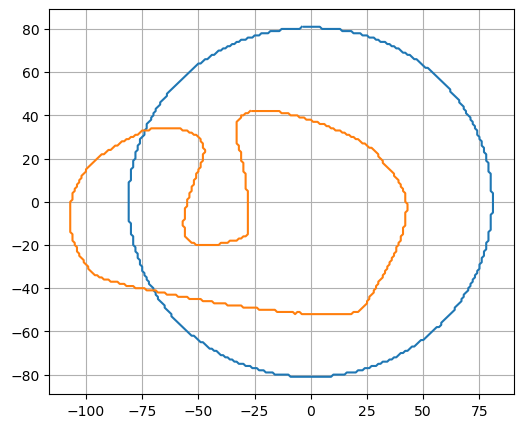

In [16]:
fig, ax = plt.subplots(figsize = (6, 5))
ax.plot(circle[:,0], -circle[:,1])
ax.plot(irloop[:,0], -irloop[:,1])
plt.grid('True')

In [19]:
n = 4
scale = 1.0
print(func(irloop[::n, 0]/scale, -irloop[::n, 1]/scale) / func(circle[::n, 0]/scale, -circle[::n, 1]/scale))

1.8506559413107162
